<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Conditioned-unet" data-toc-modified-id="Conditioned-unet-1">Conditioned unet</a></span><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1.1">Goal</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-1.2">Imports</a></span></li><li><span><a href="#First-steps" data-toc-modified-id="First-steps-1.3">First steps</a></span></li><li><span><a href="#Modifying-the-model-configuration" data-toc-modified-id="Modifying-the-model-configuration-1.4">Modifying the model configuration</a></span></li><li><span><a href="#Save-and-load-the-model" data-toc-modified-id="Save-and-load-the-model-1.5">Save and load the model</a></span></li><li><span><a href="#Customizing-the-model" data-toc-modified-id="Customizing-the-model-1.6">Customizing the model</a></span></li><li><span><a href="#Try-the-model-on-real-data" data-toc-modified-id="Try-the-model-on-real-data-1.7">Try the model on real data</a></span><ul class="toc-item"><li><span><a href="#Create-model" data-toc-modified-id="Create-model-1.7.1">Create model</a></span></li><li><span><a href="#Create-data" data-toc-modified-id="Create-data-1.7.2">Create data</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-1.7.3">Train</a></span></li><li><span><a href="#Train-more-and-save-to-file" data-toc-modified-id="Train-more-and-save-to-file-1.7.4">Train more and save to file</a></span></li></ul></li><li><span><a href="#Play-with-trained-model" data-toc-modified-id="Play-with-trained-model-1.8">Play with trained model</a></span></li></ul></li></ul></div>

# Conditioned unet

## Goal

On this notebook I want to explore the github repo https://github.com/gabolsgabs/cunet to see if I can reuse it for Luxai challenge.

## Imports

In [33]:
# Use this to reload changes in python scripts
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras as keras
from kaggle_environments import make

from luxai.utils import render_game_in_html, set_random_seed
from luxai.cunet import cunet_model, cunet_luxai_model, config
from luxai.input_features import make_input
from luxai.output_features import (
    create_actions_mask, create_output_features,
    UNIT_ACTIONS_MAP, CITY_ACTIONS_MAP)

In [35]:
plt.plot()
plt.close('all')
plt.rcParams["figure.figsize"] = (30, 5)  
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['font.size'] = 16

## First steps

In [4]:
model = cunet_model()
model.summary()

2021-10-17 09:32:00.627449: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-17 09:32:01.428169: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22308 MB memory:  -> device: 0, name: GeForce RTX 3090, pci bus id: 0000:17:00.0, compute capability: 8.6
2021-10-17 09:32:01.429090: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 21543 MB memory:  -> device: 1, name: GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1, 4)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 1, 16)        80          input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1, 64)        1088        dense[0][0]                      
__________________________________________________________________________________________________
dropout (Dropout)               (None, 1, 64)        0           dense_1[0][0]                    
______________________________________________________________________________________________

/home/gbarbadillo/miniconda3/envs/luxai/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [5]:
model.inputs

[<KerasTensor: shape=(None, 512, 128, 1) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 1, 4) dtype=float32 (created by layer 'input_2')>]

In [6]:
model.predict([np.zeros((1, 512, 128, 1)), np.zeros((1, 1, 4))]).shape

2021-10-17 09:32:02.247492: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-17 09:32:03.150217: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2021-10-17 09:32:04.863980: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2021-10-17 09:32:04.865936: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-10-17 09:32:04.867391: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-10-17 09:32:04.867430: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2021-10-17 09:32:04.868560: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such fi

(1, 512, 128, 1)

It does not find ptxas, even after installing cudatoolkit-dev

In [6]:
model.predict([np.zeros((1, 512, 128, 1)), np.zeros((1, 1, 4))]).shape

2021-10-17 07:57:05.423086: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-17 07:57:06.301671: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2021-10-17 07:57:08.085132: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2021-10-17 07:57:08.087223: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-10-17 07:57:08.088158: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-10-17 07:57:08.088196: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2021-10-17 07:57:08.089225: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such fi

(1, 512, 128, 1)

## Modifying the model configuration

In [10]:
config.N_LAYERS = 2

In [11]:
model = cunet_model()
model.summaryry()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1, 4)]       0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 1, 16)        80          input_4[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 1, 64)        1088        dense_5[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 1, 64)        0           dense_6[0][0]                    
____________________________________________________________________________________________

/home/gbarbadillo/miniconda3/envs/luxai/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


We have reduced the number of parameters from 9M to 49k, so this shows we can modify the model configuration very easily.

## Save and load the model

Let's verify that we can save and load the model.

In [12]:
model.save('delete.h5')

/home/gbarbadillo/miniconda3/envs/luxai/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [14]:
loaded_model = keras.models.load_model('delete.h5')

In [15]:
loaded_model.predict([np.zeros((1, 512, 128, 1)), np.zeros((1, 1, 4))]).shape

(1, 512, 128, 1)

In [21]:
random_input = [np.random.normal(size=(1, 512, 128, 1)), np.random.normal(size=(1, 1, 4))]
pred = model.predict(random_input)
pred2 = loaded_model.predict(random_input)

np.mean(pred2 == pred)

1.0

There does not seem to be a problem.

## Customizing the model

I have tried setting the x, and y to None but did not work. The output of the model needs to be slighlty different, so I'm going to modify the function for creating the model.

/home/gbarbadillo/miniconda3/envs/luxai/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model_14"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_16 (InputLayer)                            [(None, 1, 12)]                  0                                                                   
______________________________________________________________________________________________________________________________________________________
board_input (InputLayer)                         [(None, 32, 32, 22)]             0                                                                   
______________________________________________________________________________________________________________________________________________________
dense_22 (Dense)                                 (None, 1, 16)              

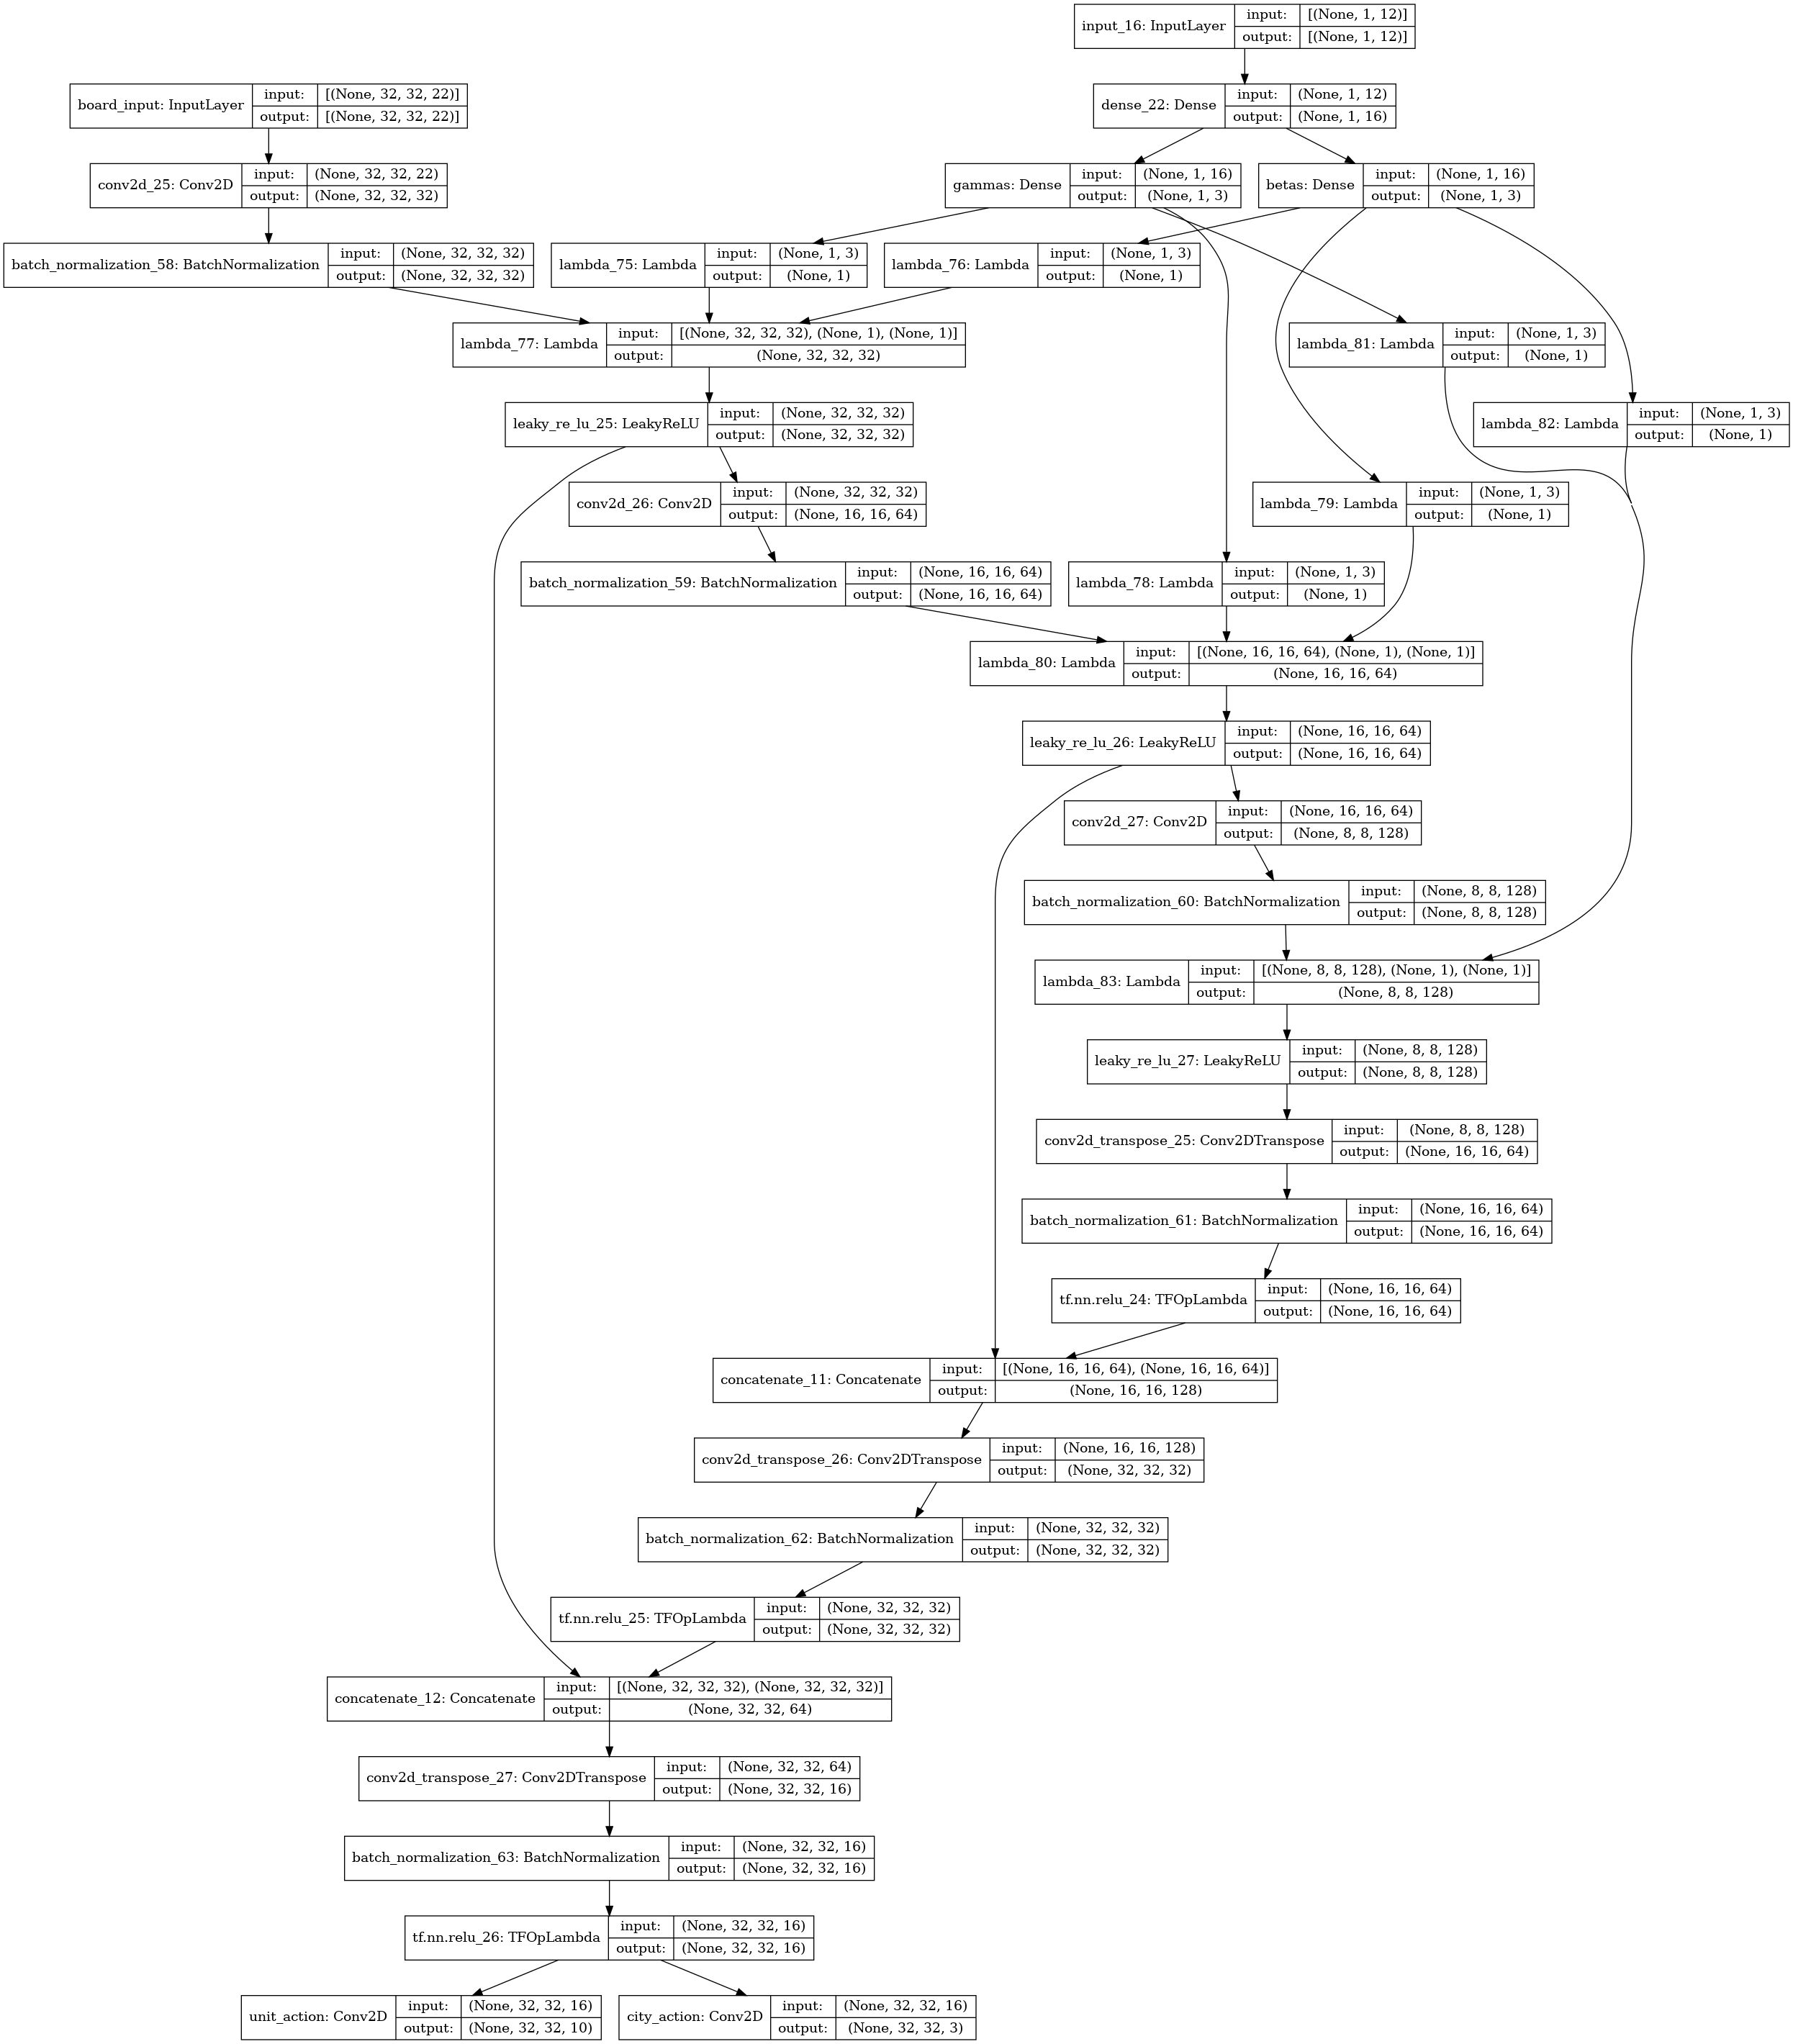

In [33]:
# Unet parameters
config.INPUT_SHAPE = [32, 32, 22] #[512, 128, 1]
config.FILTERS_LAYER_1 = 32 # 16
config.N_LAYERS = 3 # 6
config.ACT_LAST = 'sigmoid' # sigmoid
# Condition parameters
config.Z_DIM = 12 # 4
config.CONTROL_TYPE = 'dense' # dense
config.FILM_TYPE = 'simple' # simple
config.N_NEURONS = [16] # [16, 64, 256]
config.N_CONDITIONS = config.N_LAYERS # 6 this should be the same as the number of layers


model = cunet_luxai_model(config)
model.summary(line_length=150)
keras.utils.plot_model(model, show_shapes=True)

## Try the model on real data

### Create model

In [4]:
# Unet parameters
config.INPUT_SHAPE = [12, 12, 23] #[512, 128, 1]
config.FILTERS_LAYER_1 = 32 # 16
config.N_LAYERS = 3 # 6
config.ACT_LAST = 'sigmoid' # sigmoid
# Condition parameters
config.Z_DIM = 13 # 4
config.CONTROL_TYPE = 'dense' # dense
config.FILM_TYPE = 'simple' # simple
config.N_NEURONS = [16] # [16, 64, 256]
config.N_CONDITIONS = config.N_LAYERS # 6 this should be the same as the number of layers
# Other
config.LR = 1e-3 # 1e-3


model = cunet_luxai_model(config)

2021-10-18 06:54:53.011354: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-18 06:54:53.011405: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-10-18 06:54:53.011431: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-10-18 06:54:53.011459: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2021-10-18 06:54:53.011486: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

### Create data

In [5]:
filepath  = '../data/sample_games/20210924_seed1_172steps.json'
with open(filepath, 'r') as f:
    match = json.load(f)

In [6]:
board, features, unit_output, city_output = [], [], [], []
for step in range(len(match['steps']) - 1):
    observation = match['steps'][step][0]['observation']
    actions = match['steps'][step+1][0]['action'] # notice the step + 150

    ret = make_input(observation)
    board.append(ret[0])
    features.append(ret[1])
    active_units_to_position, active_cities_to_position, units_to_position = ret[2:]
    unit_actions_mask = create_actions_mask(active_units_to_position, observation)
    city_actions_mask = create_actions_mask(active_cities_to_position, observation)
    unit_actions, city_actions = create_output_features(actions, units_to_position, observation)
    unit_output.append(np.concatenate([unit_actions, unit_actions_mask], axis=-1))
    city_output.append(np.concatenate([city_actions, city_actions_mask], axis=-1))

board = np.array(board, dtype=np.float32)
features = np.array(features, dtype=np.float32)
unit_output = np.array(unit_output, dtype=np.float32)
city_output = np.array(city_output, dtype=np.float32)

### Train

In [7]:
board.shape, features.shape, unit_output.shape, city_output.shape

((199, 12, 12, 23), (199, 1, 13), (199, 12, 12, 11), (199, 12, 12, 4))

In [8]:
model.inputs

[<KerasTensor: shape=(None, 12, 12, 23) dtype=float32 (created by layer 'board_input')>,
 <KerasTensor: shape=(None, 1, 13) dtype=float32 (created by layer 'input_1')>]

In [9]:
model.fit(x=[board, features], y=[unit_output, city_output], epochs=100)

2021-10-18 06:54:53.587370: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
7/7 [==============================] - 1s 25ms/step - loss: 1.2657 - unit_action_loss: 0.7122 - city_action_loss: 0.5535 - unit_action_masked_error: 0.4608 - city_action_masked_error: 0.1983
Epoch 2/100
7/7 [==============================] - 0s 23ms/step - loss: 0.8927 - unit_action_loss: 0.6236 - city_action_loss: 0.2691 - unit_action_masked_error: 0.3261 - city_action_masked_error: 0.0495
Epoch 3/100
7/7 [==============================] - 0s 22ms/step - loss: 0.7393 - unit_action_loss: 0.5465 - city_action_loss: 0.1928 - unit_action_masked_error: 0.2485 - city_action_masked_error: 0.0530
Epoch 4/100
7/7 [==============================] - 0s 23ms/step - loss: 0.6320 - unit_action_loss: 0.4744 - city_action_loss: 0.1576 - unit_action_masked_error: 0.1798 - city_action_masked_error: 0.0299
Epoch 5/100
7/7 [==============================] - 0s 21ms/step - loss: 0.5552 - unit_action_loss: 0.4211 - city_action_loss: 0.1341 - unit_action_masked_error: 0.1469 - city_action_masked

7/7 [==============================] - 0s 24ms/step - loss: 0.0192 - unit_action_loss: 0.0149 - city_action_loss: 0.0043 - unit_action_masked_error: 0.0025 - city_action_masked_error: 9.8328e-04
Epoch 81/100
7/7 [==============================] - 0s 24ms/step - loss: 0.0170 - unit_action_loss: 0.0123 - city_action_loss: 0.0047 - unit_action_masked_error: 0.0027 - city_action_masked_error: 7.3746e-04
Epoch 82/100
7/7 [==============================] - 0s 25ms/step - loss: 0.0158 - unit_action_loss: 0.0119 - city_action_loss: 0.0040 - unit_action_masked_error: 0.0019 - city_action_masked_error: 6.8306e-04
Epoch 83/100
7/7 [==============================] - 0s 23ms/step - loss: 0.0159 - unit_action_loss: 0.0120 - city_action_loss: 0.0039 - unit_action_masked_error: 0.0023 - city_action_masked_error: 9.9206e-04
Epoch 84/100
7/7 [==============================] - 0s 24ms/step - loss: 0.0155 - unit_action_loss: 0.0104 - city_action_loss: 0.0051 - unit_action_masked_error: 0.0016 - city_actio

We can see that the model is able to reduce the loss a lot. Let's check the predictions.

Also the error gets down to very good numbers. It starts around 50% because they are binary labels.

In [10]:
pred = model.predict([board, features])

In [11]:
unit_output.shape

(199, 12, 12, 11)

In [12]:
def show_unit_action_predictions(step):
    n_cols = len(UNIT_ACTIONS_MAP)
    for name, idx in UNIT_ACTIONS_MAP.items():
        plt.subplot(1, n_cols, idx % n_cols + 1)
        action_map = unit_output[step, :, :, idx]
        plt.imshow(np.transpose(action_map), vmax=1, vmin=0)
        plt.title('%s (%.1f)' % (name, np.max(action_map)))
    plt.suptitle('Labels')
    plt.show()
    for name, idx in UNIT_ACTIONS_MAP.items():
        plt.subplot(1, n_cols, idx % n_cols + 1)
        action_map = pred[0][step][:, :, idx]*unit_output[step, :, :, -1]
        plt.imshow(np.transpose(action_map), vmax=1, vmin=0)
        plt.title('%s (%.1f)' % (name, np.max(action_map)))
    plt.suptitle('Masked predictions')
    plt.show()
    for name, idx in UNIT_ACTIONS_MAP.items():
        plt.subplot(1, n_cols, idx % n_cols + 1)
        action_map = pred[0][step][:, :, idx]
        plt.imshow(np.transpose(action_map), vmax=1, vmin=0)
        plt.title('%s (%.1f)' % (name, np.max(action_map)))
    plt.suptitle('Unmasked predictions')
    plt.show()
    
def show_city_action_predictions(step):
    n_cols = len(CITY_ACTIONS_MAP)
    for name, idx in CITY_ACTIONS_MAP.items():
        plt.subplot(1, n_cols, idx % n_cols + 1)
        action_map = city_output[step, :, :, idx]
        plt.imshow(np.transpose(action_map), vmax=1, vmin=0)
        plt.title('%s (%.1f)' % (name, np.max(action_map)))
    plt.suptitle('Labels')
    plt.show()
    for name, idx in CITY_ACTIONS_MAP.items():
        plt.subplot(1, n_cols, idx % n_cols + 1)
        action_map = pred[1][step][:, :, idx]*city_output[step, :, :, -1]
        plt.imshow(np.transpose(action_map), vmax=1, vmin=0)
        plt.title('%s (%.1f)' % (name, np.max(action_map)))
    plt.suptitle('Masked predictions')
    plt.show()
    for name, idx in CITY_ACTIONS_MAP.items():
        plt.subplot(1, n_cols, idx % n_cols + 1)
        action_map = pred[1][step][:, :, idx]
        plt.imshow(np.transpose(action_map), vmax=1, vmin=0)
        plt.title('%s (%.1f)' % (name, np.max(action_map)))
    plt.suptitle('Unmasked predictions')
    plt.show()

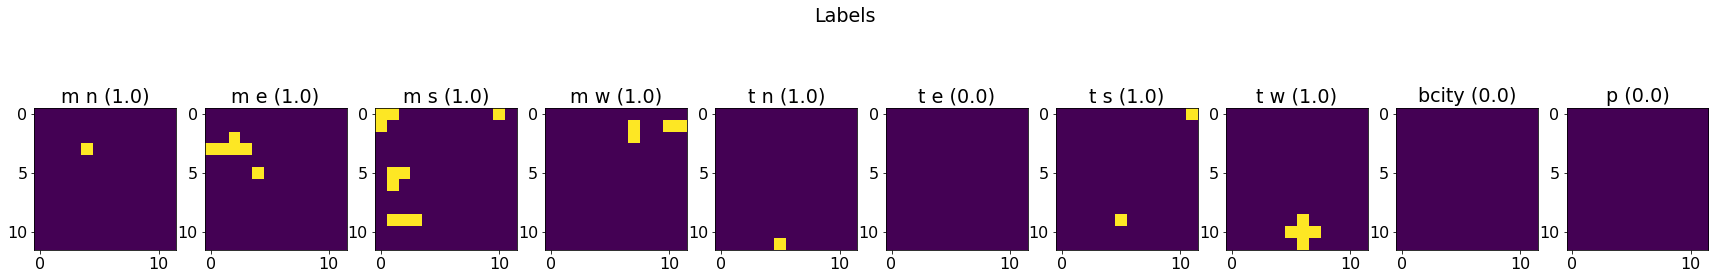

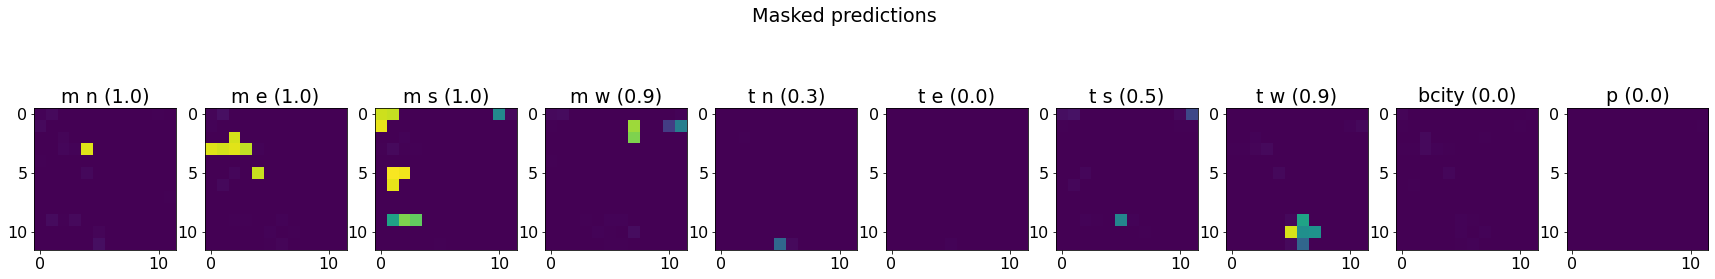

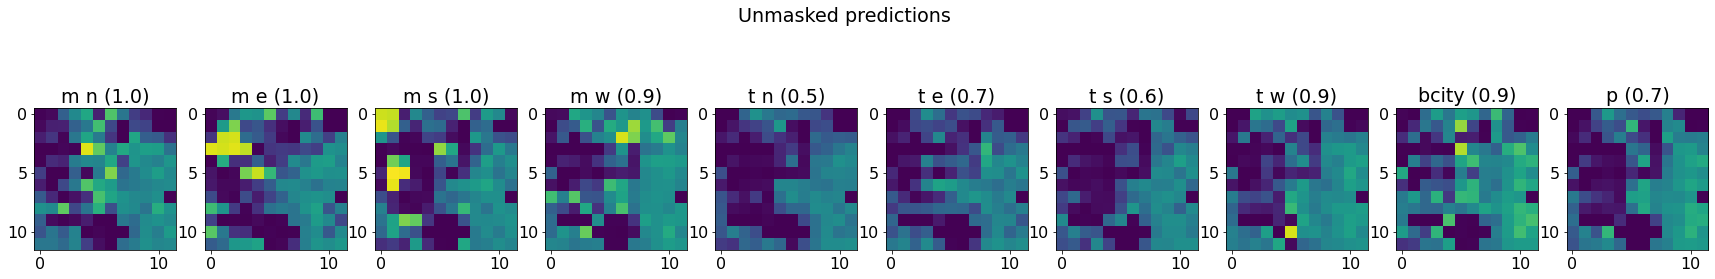

In [13]:
show_unit_action_predictions(160)

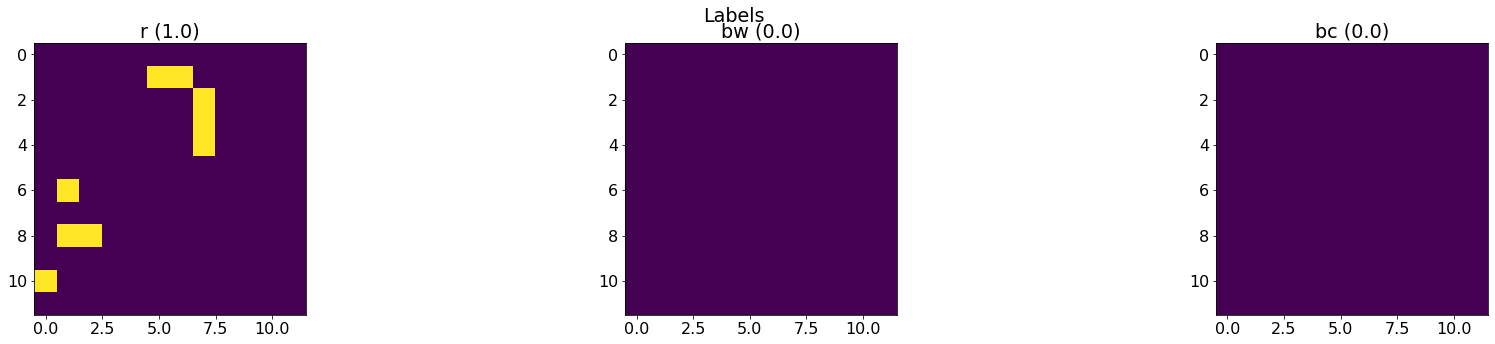

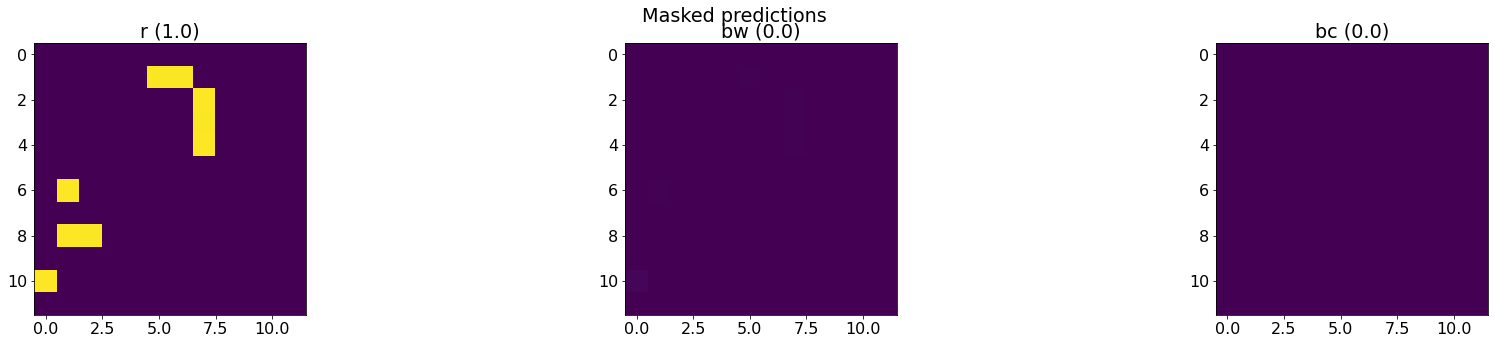

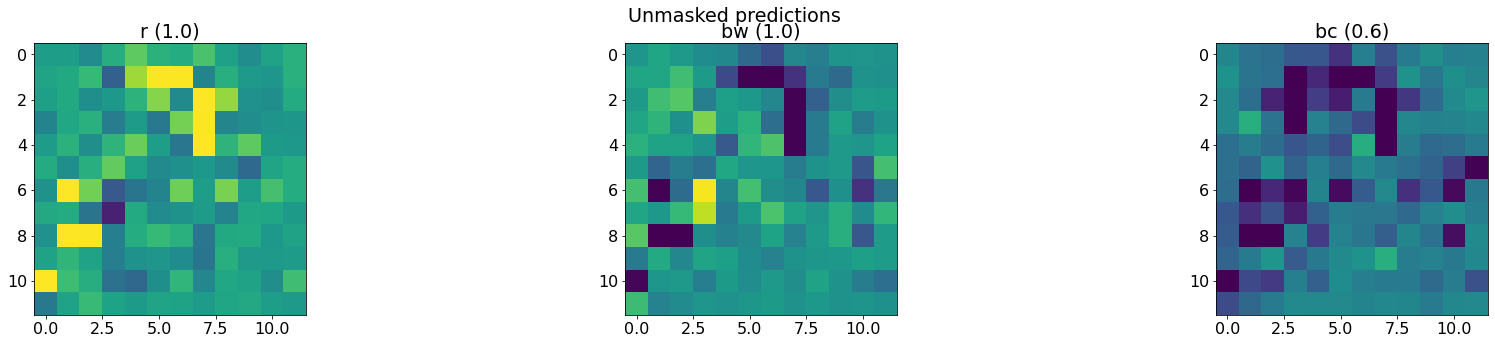

In [14]:
show_city_action_predictions(52)

### Train more and save to file

I want to see that it is able to play like me, let's play for longer to reduce the error even more.

In [15]:
model.fit(x=[board, features], y=[unit_output, city_output], epochs=100)

Epoch 1/100
7/7 [==============================] - 0s 23ms/step - loss: 0.0123 - unit_action_loss: 0.0074 - city_action_loss: 0.0049 - unit_action_masked_error: 0.0013 - city_action_masked_error: 9.9206e-04
Epoch 2/100
7/7 [==============================] - 0s 26ms/step - loss: 0.0103 - unit_action_loss: 0.0076 - city_action_loss: 0.0028 - unit_action_masked_error: 0.0014 - city_action_masked_error: 3.5558e-04
Epoch 3/100
7/7 [==============================] - 0s 24ms/step - loss: 0.0108 - unit_action_loss: 0.0074 - city_action_loss: 0.0035 - unit_action_masked_error: 0.0014 - city_action_masked_error: 9.4646e-04
Epoch 4/100
7/7 [==============================] - 0s 24ms/step - loss: 0.0106 - unit_action_loss: 0.0068 - city_action_loss: 0.0038 - unit_action_masked_error: 0.0015 - city_action_masked_error: 0.0034 
Epoch 5/100
7/7 [==============================] - 0s 23ms/step - loss: 0.0142 - unit_action_loss: 0.0069 - city_action_loss: 0.0073 - unit_action_masked_error: 0.0013 - city_

7/7 [==============================] - 0s 22ms/step - loss: 0.0041 - unit_action_loss: 0.0035 - city_action_loss: 5.6350e-04 - unit_action_masked_error: 0.0013 - city_action_masked_error: 0.0000e+00
Epoch 79/100
7/7 [==============================] - 0s 16ms/step - loss: 0.0037 - unit_action_loss: 0.0032 - city_action_loss: 5.4078e-04 - unit_action_masked_error: 7.7922e-04 - city_action_masked_error: 0.0000e+00
Epoch 80/100
7/7 [==============================] - 0s 23ms/step - loss: 0.0044 - unit_action_loss: 0.0038 - city_action_loss: 5.6652e-04 - unit_action_masked_error: 0.0011 - city_action_masked_error: 0.0000e+00
Epoch 81/100
7/7 [==============================] - 0s 26ms/step - loss: 0.0037 - unit_action_loss: 0.0032 - city_action_loss: 4.9364e-04 - unit_action_masked_error: 0.0021 - city_action_masked_error: 0.0000e+00
Epoch 82/100
7/7 [==============================] - 0s 23ms/step - loss: 0.0046 - unit_action_loss: 0.0040 - city_action_loss: 5.4703e-04 - unit_action_masked_er

In [16]:
model.fit(x=[board, features], y=[unit_output, city_output], epochs=100)

Epoch 1/100
7/7 [==============================] - 0s 20ms/step - loss: 0.0026 - unit_action_loss: 0.0021 - city_action_loss: 5.0143e-04 - unit_action_masked_error: 5.0231e-04 - city_action_masked_error: 0.0000e+00
Epoch 2/100
7/7 [==============================] - 0s 22ms/step - loss: 0.0025 - unit_action_loss: 0.0020 - city_action_loss: 4.6258e-04 - unit_action_masked_error: 6.4629e-04 - city_action_masked_error: 0.0000e+00
Epoch 3/100
7/7 [==============================] - 0s 23ms/step - loss: 0.0024 - unit_action_loss: 0.0021 - city_action_loss: 3.1538e-04 - unit_action_masked_error: 6.2802e-04 - city_action_masked_error: 0.0000e+00
Epoch 4/100
7/7 [==============================] - 0s 21ms/step - loss: 0.0023 - unit_action_loss: 0.0019 - city_action_loss: 3.6697e-04 - unit_action_masked_error: 4.7624e-04 - city_action_masked_error: 0.0000e+00
Epoch 5/100
7/7 [==============================] - 0s 19ms/step - loss: 0.0023 - unit_action_loss: 0.0019 - city_action_loss: 3.7525e-04 - u

7/7 [==============================] - 0s 25ms/step - loss: 0.0017 - unit_action_loss: 0.0015 - city_action_loss: 2.8009e-04 - unit_action_masked_error: 3.9136e-04 - city_action_masked_error: 0.0000e+00
Epoch 78/100
7/7 [==============================] - 0s 25ms/step - loss: 0.0016 - unit_action_loss: 0.0014 - city_action_loss: 2.2099e-04 - unit_action_masked_error: 0.0010 - city_action_masked_error: 0.0000e+00     
Epoch 79/100
7/7 [==============================] - 0s 25ms/step - loss: 0.0020 - unit_action_loss: 0.0017 - city_action_loss: 2.3321e-04 - unit_action_masked_error: 4.5822e-04 - city_action_masked_error: 0.0000e+00
Epoch 80/100
7/7 [==============================] - 0s 25ms/step - loss: 0.0036 - unit_action_loss: 0.0034 - city_action_loss: 2.5820e-04 - unit_action_masked_error: 7.3189e-04 - city_action_masked_error: 0.0000e+00
Epoch 81/100
7/7 [==============================] - 0s 26ms/step - loss: 0.0034 - unit_action_loss: 0.0032 - city_action_loss: 2.3571e-04 - unit_act

In [19]:
model.optimizer.learning_rate = 1e-4
model.fit(x=[board, features], y=[unit_output, city_output], epochs=100)

Epoch 1/100
7/7 [==============================] - 0s 21ms/step - loss: 0.0013 - unit_action_loss: 0.0012 - city_action_loss: 1.8587e-04 - unit_action_masked_error: 3.6560e-04 - city_action_masked_error: 0.0000e+00 
Epoch 2/100
7/7 [==============================] - 0s 24ms/step - loss: 0.0013 - unit_action_loss: 0.0011 - city_action_loss: 1.5603e-04 - unit_action_masked_error: 3.6373e-04 - city_action_masked_error: 0.0000e+00
Epoch 3/100
7/7 [==============================] - 0s 23ms/step - loss: 0.0012 - unit_action_loss: 0.0010 - city_action_loss: 1.5821e-04 - unit_action_masked_error: 2.0082e-04 - city_action_masked_error: 0.0000e+00 
Epoch 4/100
7/7 [==============================] - 0s 25ms/step - loss: 0.0012 - unit_action_loss: 0.0010 - city_action_loss: 1.7951e-04 - unit_action_masked_error: 2.4072e-04 - city_action_masked_error: 0.0000e+00 
Epoch 5/100
7/7 [==============================] - 0s 24ms/step - loss: 0.0013 - unit_action_loss: 0.0011 - city_action_loss: 1.8531e-04 

7/7 [==============================] - 0s 19ms/step - loss: 0.0010 - unit_action_loss: 8.6708e-04 - city_action_loss: 1.6326e-04 - unit_action_masked_error: 9.6962e-05 - city_action_masked_error: 0.0000e+00
Epoch 76/100
7/7 [==============================] - 0s 18ms/step - loss: 0.0010 - unit_action_loss: 8.9533e-04 - city_action_loss: 1.3665e-04 - unit_action_masked_error: 5.1132e-04 - city_action_masked_error: 0.0000e+00
Epoch 77/100
7/7 [==============================] - 0s 18ms/step - loss: 0.0011 - unit_action_loss: 8.1901e-04 - city_action_loss: 2.3695e-04 - unit_action_masked_error: 8.7292e-05 - city_action_masked_error: 0.0000e+00
Epoch 78/100
7/7 [==============================] - 0s 17ms/step - loss: 0.0011 - unit_action_loss: 8.9044e-04 - city_action_loss: 1.6887e-04 - unit_action_masked_error: 1.6131e-04 - city_action_masked_error: 0.0000e+00
Epoch 79/100
7/7 [==============================] - 0s 17ms/step - loss: 0.0011 - unit_action_loss: 9.6453e-04 - city_action_loss: 1.

In [20]:
model.optimizer.learning_rate = 1e-5
model.fit(x=[board, features], y=[unit_output, city_output], epochs=100)

Epoch 1/100
7/7 [==============================] - 0s 21ms/step - loss: 9.7145e-04 - unit_action_loss: 8.4532e-04 - city_action_loss: 1.2613e-04 - unit_action_masked_error: 1.5432e-04 - city_action_masked_error: 0.0000e+00
Epoch 2/100
7/7 [==============================] - 0s 25ms/step - loss: 0.0010 - unit_action_loss: 8.8492e-04 - city_action_loss: 1.2090e-04 - unit_action_masked_error: 2.1411e-04 - city_action_masked_error: 0.0000e+00
Epoch 3/100
7/7 [==============================] - 0s 25ms/step - loss: 8.8483e-04 - unit_action_loss: 7.6179e-04 - city_action_loss: 1.2303e-04 - unit_action_masked_error: 1.6955e-04 - city_action_masked_error: 0.0000e+00
Epoch 4/100
7/7 [==============================] - 0s 24ms/step - loss: 0.0010 - unit_action_loss: 8.6225e-04 - city_action_loss: 1.7272e-04 - unit_action_masked_error: 2.8754e-04 - city_action_masked_error: 0.0000e+00
Epoch 5/100
7/7 [==============================] - 0s 24ms/step - loss: 9.7794e-04 - unit_action_loss: 8.1675e-04 - 

7/7 [==============================] - 0s 21ms/step - loss: 0.0010 - unit_action_loss: 7.9725e-04 - city_action_loss: 2.1279e-04 - unit_action_masked_error: 1.0582e-04 - city_action_masked_error: 0.0000e+00
Epoch 74/100
7/7 [==============================] - 0s 20ms/step - loss: 9.2286e-04 - unit_action_loss: 7.5679e-04 - city_action_loss: 1.6607e-04 - unit_action_masked_error: 2.8701e-04 - city_action_masked_error: 0.0000e+00
Epoch 75/100
7/7 [==============================] - 0s 20ms/step - loss: 9.0506e-04 - unit_action_loss: 7.6359e-04 - city_action_loss: 1.4146e-04 - unit_action_masked_error: 9.2879e-05 - city_action_masked_error: 0.0000e+00
Epoch 76/100
7/7 [==============================] - 0s 20ms/step - loss: 8.7740e-04 - unit_action_loss: 7.2925e-04 - city_action_loss: 1.4814e-04 - unit_action_masked_error: 5.6689e-05 - city_action_masked_error: 0.0000e+00
Epoch 77/100
7/7 [==============================] - 0s 20ms/step - loss: 9.4447e-04 - unit_action_loss: 7.8055e-04 - city

I'm not able to reach perfect accuracy but it is close.

In [21]:
model.save('model.h5', include_optimizer=False)

## Play with trained model

Now the goal is to see that we can play using the saved model.

In [5]:
model = keras.models.load_model('model.h5', compile=False)

In [30]:
def agent_with_model(observation, configuration):
    ret = make_input(observation)
    board, features = ret[:2]
    preds = model.predict([np.expand_dims(board, axis=0), np.expand_dims(features, axis=0)])
    active_units_to_position, active_cities_to_position, units_to_position = ret[2:]
    actions = create_actions_from_model_predictions(
        preds, active_units_to_position, active_cities_to_position, units_to_position)
    actions += create_actions_for_cities_from_model_predictions(preds[1][0], active_cities_to_position)
    return actions

def create_actions_from_model_predictions(preds, active_units_to_position, active_cities_to_position, units_to_position):
    actions = create_actions_for_units_from_model_predictions(preds[0][0], active_units_to_position, units_to_position)
    return actions
        
def create_actions_for_units_from_model_predictions(preds, active_units_to_position, units_to_position, action_threshold=0.5):
    # TODO: deal with collisions
    actions = []
    idx_to_action = {idx: name for name, idx in UNIT_ACTIONS_MAP.items()}
    for unit_id, position in active_units_to_position.items():
        x, y = position
        unit_preds = preds[x, y]
        # TODO: be able to deal with multiple units on same place
        action_idx = np.argmax(unit_preds)
        if unit_preds[action_idx] > action_threshold:
            action_key = idx_to_action[action_idx]
            actions.append(create_unit_action(action_key, unit_id))
    return actions
            
def create_unit_action(action_key, unit_id):
    action_id = action_key.split(' ')[0]
    if action_id == 'm':
        action = 'm %s %s' % (unit_id, action_key.split(' ')[-1])
        return action
    elif action_id in ['bcity', 'p']:
        action = '%s %s' % (action_id, unit_id)
        return action
    elif action_id == 't':
        # TODO: implement transfer
        return 'm %s c' % unit_id
    else:
        raise KeyError(action_id)
    
def create_actions_for_cities_from_model_predictions(preds, active_cities_to_position, action_threshold=0.5):
    actions = []
    idx_to_action = {idx: name for name, idx in CITY_ACTIONS_MAP.items()}
    for position in active_cities_to_position.values():
        x, y = position
        city_preds = preds[x, y]
        action_idx = np.argmax(city_preds)
        if city_preds[action_idx] > action_threshold:
            action_key = idx_to_action[action_idx]
            actions.append('%s %i %i' % (action_key, x, y))
    return actions

In [36]:
env = make("lux_ai_2021", debug=True, configuration={'width': 12, 'height': 12, 'seed': 1})
set_random_seed(7)
game_info = env.run([agent_with_model, '/mnt/hdd0/MEGA/AI/22 Kaggle/luxai/agents/working_title/agent.py'])
render_game_in_html(env)

Opening in existing browser session.


It is capable of playing, but it does not generalize well and since the other bot is random that creates different scenarios than training and the agent fails. 

However we have verified that we can play using a model. 

There seems to be a problem with city masks.

TODO: 

- assert that there is no action outside the mask on tests
- Verify that it's able to play like me on that match